# Projet NLP : Détection de Messages Suicidaires

## 1. Introduction et Objectifs

### 1.1 Contexte du Projet
La détection automatique de messages suicidaires dans les contenus en ligne est un enjeu crucial de santé publique. Ce projet vise à développer un modèle de classification binaire capable d'identifier les messages à risque suicidaire parmi des posts issus de forums en ligne.

### 1.2 Objectifs Spécifiques
1. **Analyse exploratoire** complète d'un dataset de messages annotés
2. **Comparaison systématique** de différentes méthodes de représentation textuelle
3. **Évaluation rigoureuse** de plusieurs algorithmes de classification
4. **Optimisation** pour maximiser le rappel (détection des vrais positifs)
5. **Analyse critique** des résultats et des limitations

### 1.3 Importance du Rappel
Dans ce contexte médical, un **faux négatif** (message suicidaire non détecté) est plus dangereux qu'un **faux positif**. Nous privilégierons donc les modèles avec un rappel élevé.

---

## 2. Chargement et Exploration Initiale des Données

In [1]:
# Importation des bibliothèques de base
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Montage de Google Drive pour accéder aux fichiers
drive.mount('/content/drive')
print("Google Drive monté avec succès")

# Définition du chemin des données
data_folder = "/content/drive/MyDrive/MIASHS/NLP/Suicide_Detection_Project/data/"
print(f"Contenu du dossier data : {os.listdir(data_folder)}")

Mounted at /content/drive
Google Drive monté avec succès
Contenu du dossier data : ['Suicide_Detection.csv']


In [2]:
# Chargement du dataset
data_path = os.path.join(data_folder, "Suicide_Detection.csv")

# Lecture avec pandas
try:
    df = pd.read_csv(data_path)
    print(f"Dataset chargé avec succès")
    print(f"   Dimensions : {df.shape[0]} lignes × {df.shape[1]} colonnes")
except FileNotFoundError:
    print(f"Fichier non trouvé à l'emplacement : {data_path}")
    # Création d'un dataframe exemple pour la démonstration
    df = pd.DataFrame({
        'text': ['Sample text 1', 'Sample text 2'],
        'class': ['suicide', 'non-suicide']
    })

Dataset chargé avec succès
   Dimensions : 232074 lignes × 3 colonnes


### 2.1 Aperçu Initial des Données

In [3]:
# Affichage des premières lignes
print("=" * 60)
print("APERÇU DU DATASET (5 premières lignes)")
print("=" * 60)
display(df.head())

# Affichage des dernières lignes pour vérifier la cohérence
print("\n" + "=" * 60)
print("DERNIÈRES LIGNES DU DATASET")
print("=" * 60)
display(df.tail())

# Informations générales sur le dataset
print("\n" + "=" * 60)
print("INFORMATIONS GÉNÉRALES")
print("=" * 60)
df.info()

# Types de données
print("\n" + "=" * 60)
print("TYPES DE DONNÉES")
print("=" * 60)
print(df.dtypes)

# Colonnes disponibles
print("\n" + "=" * 60)
print("NOMS DES COLONNES")
print("=" * 60)
print(f"Colonnes : {list(df.columns)}")

APERÇU DU DATASET (5 premières lignes)


,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide



DERNIÈRES LIGNES DU DATASET


,Unnamed: 0,text,class
232069,348103,If you don't like rock then your not going to ...,non-suicide
232070,348106,You how you can tell i have so many friends an...,non-suicide
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
232072,348108,The usual stuff you find hereI'm not posting t...,suicide
232073,348110,I still haven't beaten the first boss in Hollo...,non-suicide



INFORMATIONS GÉNÉRALES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB

TYPES DE DONNÉES
Unnamed: 0     int64
text          object
class         object
dtype: object

NOMS DES COLONNES
Colonnes : ['Unnamed: 0', 'text', 'class']


In [4]:
# Analyse des colonnes
print("\n" + "=" * 60)
print("ANALYSE DES COLONNES")
print("=" * 60)

for col in df.columns:
    print(f"\nColonne : '{col}'")
    print(f"   Type : {df[col].dtype}")
    print(f"   Valeurs uniques : {df[col].nunique()}")
    print(f"   Valeurs nulles : {df[col].isnull().sum()} ({df[col].isnull().sum()/len(df)*100:.2f}%)")

    # Aperçu des valeurs pour les colonnes catégorielles
    if df[col].dtype == 'object' and df[col].nunique() < 10:
        print(f"   Distribution :")
        for val, count in df[col].value_counts().head().items():
            print(f"     - {val} : {count} ({count/len(df)*100:.2f}%)")


ANALYSE DES COLONNES

Colonne : 'Unnamed: 0'
   Type : int64
   Valeurs uniques : 232074
   Valeurs nulles : 0 (0.00%)

Colonne : 'text'
   Type : object
   Valeurs uniques : 232074
   Valeurs nulles : 0 (0.00%)

Colonne : 'class'
   Type : object
   Valeurs uniques : 2
   Valeurs nulles : 0 (0.00%)
   Distribution :
     - suicide : 116037 (50.00%)
     - non-suicide : 116037 (50.00%)


### 2.2 Statistiques Descriptives

In [5]:
# Statistiques descriptives pour les colonnes numériques
print("=" * 60)
print("STATISTIQUES DESCRIPTIVES (colonnes numériques)")
print("=" * 60)

# Identification des colonnes numériques
numeric_cols = df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 0:
    display(df[numeric_cols].describe())
else:
    print("Aucune colonne numérique trouvée")

# Pour les colonnes textuelles, on calcule des statistiques sur la longueur
print("\n" + "=" * 60)
print("STATISTIQUES SUR LA LONGUEUR DES TEXTES")
print("=" * 60)

# Calcul de la longueur des textes
df['text_length'] = df['text'].astype(str).apply(len)

# Statistiques générales
length_stats = df['text_length'].describe()
print(f"Longueur moyenne des textes : {length_stats['mean']:.0f} caractères")
print(f"Longueur médiane : {length_stats['50%']:.0f} caractères")
print(f"Écart-type : {length_stats['std']:.0f} caractères")
print(f"Min/Max : {length_stats['min']:.0f} / {length_stats['max']:.0f} caractères")

# Statistiques par quartile
print("\nDistribution par quartiles :")
print(f"  Q1 (25%) : {length_stats['25%']:.0f} caractères")
print(f"  Q2 (50%) : {length_stats['50%']:.0f} caractères")
print(f"  Q3 (75%) : {length_stats['75%']:.0f} caractères")

# Identification des outliers
Q1 = length_stats['25%']
Q3 = length_stats['75%']
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['text_length'] < lower_bound) | (df['text_length'] > upper_bound)]
print(f"\nOutliers détectés : {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

STATISTIQUES DESCRIPTIVES (colonnes numériques)


,Unnamed: 0
count,232074.000000
mean,174152.863518
std,100500.425362
min,2.000000
25%,87049.250000
50%,174358.500000
75%,261285.750000
max,348110.000000



STATISTIQUES SUR LA LONGUEUR DES TEXTES
Longueur moyenne des textes : 690 caractères
Longueur médiane : 315 caractères
Écart-type : 1156 caractères
Min/Max : 3 / 40297 caractères

Distribution par quartiles :
  Q1 (25%) : 138 caractères
  Q2 (50%) : 315 caractères
  Q3 (75%) : 801 caractères

Outliers détectés : 20362 (8.77%)


## 3. Nettoyage et Prétraitement des Données

In [6]:
print("=" * 60)
print("ÉTAPE DE NETTOYAGE ET PRÉTRAITEMENT")
print("=" * 60)

# 3.1 Suppression des colonnes inutiles
print("\n3.1 - Suppression des colonnes inutiles")
original_cols = df.columns.tolist()

# Vérification et suppression de la colonne 'Unnamed: 0' si elle existe
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)
    print(f" Colonne 'Unnamed: 0' supprimée")
else:
    print(f" Colonne 'Unnamed: 0' non trouvée")

print(f" Colonnes restantes : {list(df.columns)}")

# 3.2 Vérification des valeurs manquantes
print("\n3.2 - Analyse des valeurs manquantes")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Valeurs Manquantes': missing_values,
    'Pourcentage': missing_percentage
})

print("Valeurs manquantes par colonne :")
display(missing_df[missing_df['Valeurs Manquantes'] > 0])

if missing_df['Valeurs Manquantes'].sum() == 0:
    print("Aucune valeur manquante détectée")
else:
    print(f" Total des valeurs manquantes : {missing_df['Valeurs Manquantes'].sum()}")

# 3.3 Vérification des doublons
print("\n3.3 - Détection des doublons")
duplicate_count = df.duplicated().sum()
print(f" Nombre de doublons exacts : {duplicate_count}")

if duplicate_count > 0:
    print(f" Pourcentage de doublons : {duplicate_count/len(df)*100:.2f}%")
    # Suppression des doublons
    df.drop_duplicates(inplace=True)
    print(f" {duplicate_count} doublons supprimés")
    print(f" Nouvelles dimensions : {df.shape}")
else:
    print(" Aucun doublon détecté")

# 3.4 Vérification des doublons dans le texte seulement
print("\n3.4 - Détection des textes identiques")
text_duplicates = df['text'].duplicated().sum()
print(f" Textes identiques : {text_duplicates}")

# 3.5 Normalisation basique du texte
print("\n3.5 - Normalisation du texte")

# Conversion en minuscules
df['text_clean'] = df['text'].astype(str).str.lower()

# Suppression des espaces superflus
df['text_clean'] = df['text_clean'].str.strip()

# Remplacement des multiples espaces par un seul
df['text_clean'] = df['text_clean'].str.replace(r'\s+', ' ', regex=True)

print(" Texte normalisé (minuscules, espaces nettoyés)")

# 3.6 Vérification des classes
print("\n3.6 - Analyse des classes cibles")
if 'class' in df.columns:
    class_distribution = df['class'].value_counts()
    class_percentage = df['class'].value_counts(normalize=True) * 100

    print("Distribution des classes :")
    for cls, count in class_distribution.items():
        perc = class_percentage[cls]
        print(f"   {cls} : {count} échantillons ({perc:.1f}%)")

    # Calcul de l'équilibre
    balance_ratio = class_distribution.min() / class_distribution.max()
    print(f"\n Ratio d'équilibre : {balance_ratio:.3f}")
    if balance_ratio > 0.7:
        print(" Dataset relativement équilibré")
    elif balance_ratio > 0.4:
        print("  Dataset modérément déséquilibré")
    else:
        print("  Dataset fortement déséquilibré - stratégies d'équilibrage recommandées")

print("\n" + "=" * 60)
print("APERÇU APRÈS NETTOYAGE")
print("=" * 60)
print(f"Dimensions finales : {df.shape}")
display(df[['text_clean', 'class']].head())

ÉTAPE DE NETTOYAGE ET PRÉTRAITEMENT

3.1 - Suppression des colonnes inutiles
 Colonne 'Unnamed: 0' supprimée
 Colonnes restantes : ['text', 'class', 'text_length']

3.2 - Analyse des valeurs manquantes
Valeurs manquantes par colonne :


,Valeurs Manquantes,Pourcentage


Aucune valeur manquante détectée

3.3 - Détection des doublons
 Nombre de doublons exacts : 0
 Aucun doublon détecté

3.4 - Détection des textes identiques
 Textes identiques : 0

3.5 - Normalisation du texte
 Texte normalisé (minuscules, espaces nettoyés)

3.6 - Analyse des classes cibles
Distribution des classes :
   suicide : 116037 échantillons (50.0%)
   non-suicide : 116037 échantillons (50.0%)

 Ratio d'équilibre : 1.000
 Dataset relativement équilibré

APERÇU APRÈS NETTOYAGE
Dimensions finales : (232074, 4)


,text_clean,class
0,ex wife threatening suiciderecently i left my ...,suicide
1,am i weird i don't get affected by compliments...,non-suicide
2,finally 2020 is almost over... so i can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"i’m so losthello, my name is adam (16) and i’v...",suicide


## 4. Analyse Exploratoire Approfondie

ANALYSE EXPLORATOIRE APPROFONDIE

4.1 - Distribution des classes

4.2 - Analyse de la longueur des textes
   suicide : Moyenne = 1050, Médiane = 653
   non-suicide : Moyenne = 329, Médiane = 165

4.3 - Distribution globale de la longueur

4.4 - Analyse lexicale globale

4.5 - Mots caractéristiques par classe

   Top 10 mots - suicide:
     just: 204419
     don: 159963
     like: 131636
     want: 128367
     life: 113053
     feel: 108126
     know: 106737
     ve: 105674
     people: 73096
     time: 70863

   Top 10 mots - non-suicide:
     filler: 54601
     just: 53668
     like: 50561
     don: 29253
     know: 24925
     people: 22147
     fuck: 21525
     want: 20518
     day: 18801
     really: 18425

4.6 - Analyse des phrases


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


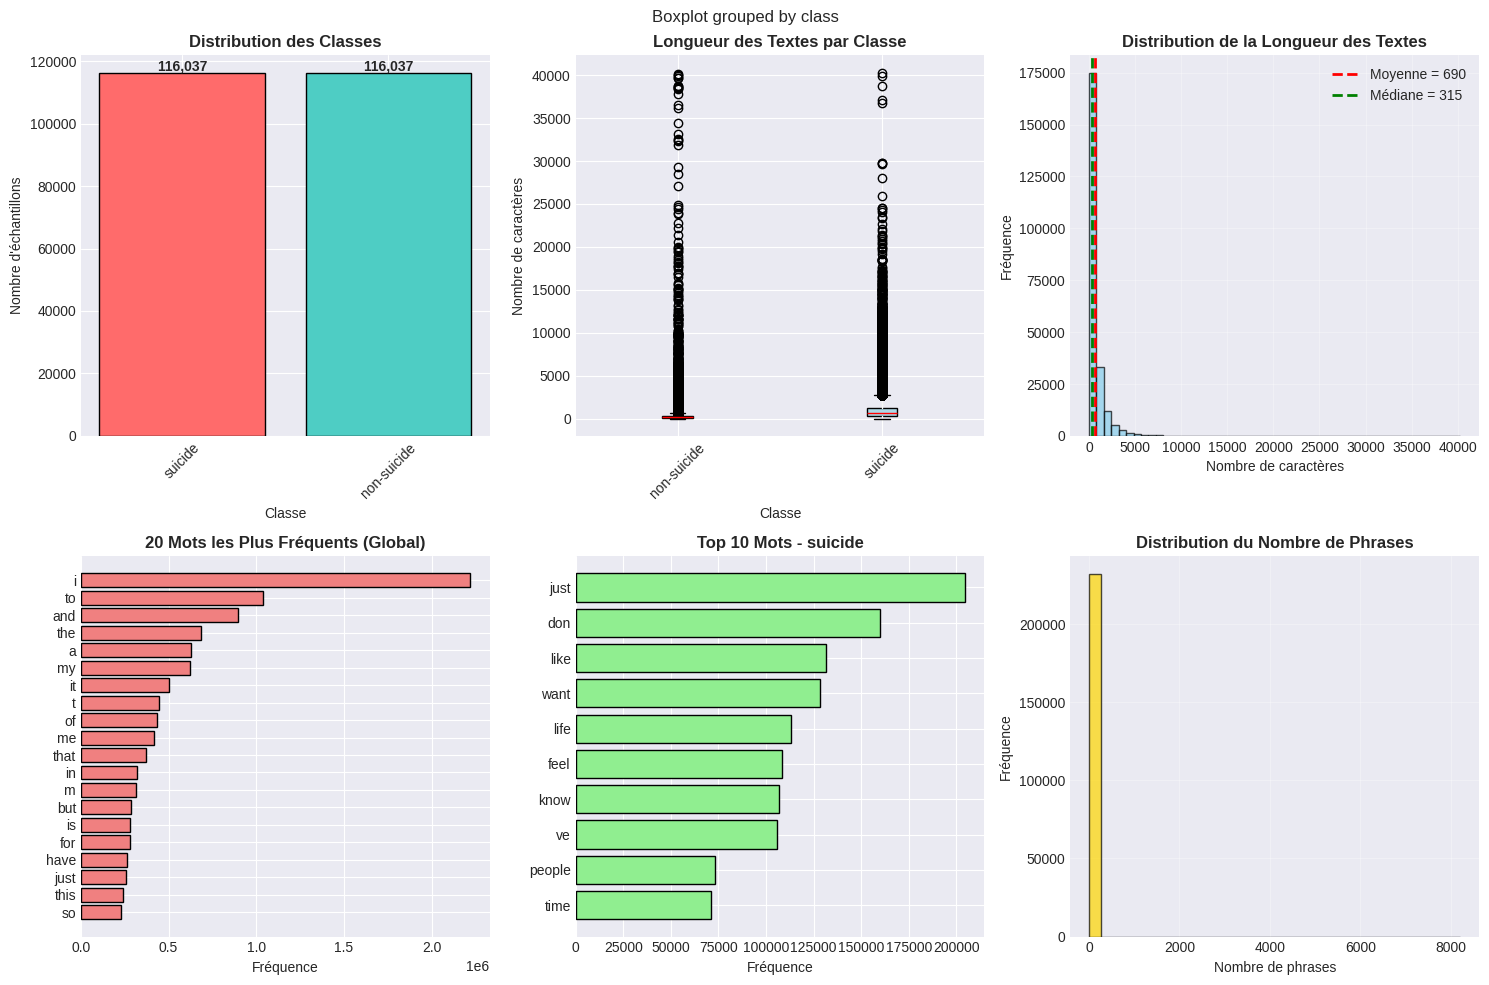


STATISTIQUES SUPPLÉMENTAIRES

  Statistiques de longueur :
   Longueur moyenne du texte : 690 caractères
   Longueur médiane : 315 caractères
   Nombre moyen de phrases : 8.2
   Mots par phrase (moyenne) : 20.9

  Taille du vocabulaire unique : 139,484 mots
   Total des mots : 31,585,623
   Richesse lexicale (types/tokens) : 0.004

  Qualité des données :
   Textes vides : 0
   Textes très courts (<10 caractères) : 29


In [7]:
print("=" * 60)
print("ANALYSE EXPLORATOIRE APPROFONDIE")
print("=" * 60)

# Configuration des graphiques
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Analyse Exploratoire des Données', fontsize=16, fontweight='bold')

# 4.1 Distribution des classes
print("\n4.1 - Distribution des classes")
ax1 = axes[0, 0]
class_counts = df['class'].value_counts()
colors = ['#FF6B6B', '#4ECDC4'] if len(class_counts) == 2 else None
bars = ax1.bar(class_counts.index, class_counts.values, color=colors, edgecolor='black')

# Ajout des annotations
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:,}', ha='center', va='bottom', fontweight='bold')

ax1.set_title('Distribution des Classes', fontweight='bold')
ax1.set_ylabel('Nombre d\'échantillons')
ax1.set_xlabel('Classe')
ax1.tick_params(axis='x', rotation=45)

# 4.2 Longueur des textes par classe
print("\n4.2 - Analyse de la longueur des textes")
ax2 = axes[0, 1]

# Calcul des statistiques de longueur par classe
class_lengths = {}
for cls in df['class'].unique():
    lengths = df[df['class'] == cls]['text_length']
    class_lengths[cls] = {
        'mean': lengths.mean(),
        'median': lengths.median(),
        'std': lengths.std()
    }
    print(f"   {cls} : Moyenne = {lengths.mean():.0f}, Médiane = {lengths.median():.0f}")

# Boxplot
df.boxplot(column='text_length', by='class', ax=ax2, patch_artist=True,
           boxprops=dict(facecolor='lightblue', color='black'),
           medianprops=dict(color='red'))
ax2.set_title('Longueur des Textes par Classe', fontweight='bold')
ax2.set_ylabel('Nombre de caractères')
ax2.set_xlabel('Classe')
ax2.tick_params(axis='x', rotation=45)

# 4.3 Histogramme des longueurs de texte
print("\n4.3 - Distribution globale de la longueur")
ax3 = axes[0, 2]
ax3.hist(df['text_length'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax3.axvline(df['text_length'].mean(), color='red', linestyle='--', linewidth=2,
            label=f'Moyenne = {df["text_length"].mean():.0f}')
ax3.axvline(df['text_length'].median(), color='green', linestyle='--', linewidth=2,
            label=f'Médiane = {df["text_length"].median():.0f}')
ax3.set_title('Distribution de la Longueur des Textes', fontweight='bold')
ax3.set_xlabel('Nombre de caractères')
ax3.set_ylabel('Fréquence')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4.4 Top 20 des mots les plus fréquents (global)
print("\n4.4 - Analyse lexicale globale")
from collections import Counter
import re

# Tokenization simple
all_words = []
for text in df['text_clean']:
    # Extraction des mots (simplifié)
    words = re.findall(r'\b[a-z]+\b', text.lower())
    all_words.extend(words)

word_freq = Counter(all_words)
top_words = word_freq.most_common(20)

ax4 = axes[1, 0]
words, counts = zip(*top_words)
y_pos = np.arange(len(words))
ax4.barh(y_pos, counts, color='lightcoral', edgecolor='black')
ax4.set_yticks(y_pos)
ax4.set_yticklabels(words)
ax4.invert_yaxis()
ax4.set_title('20 Mots les Plus Fréquents (Global)', fontweight='bold')
ax4.set_xlabel('Fréquence')

# 4.5 Comparaison fréquences par classe
print("\n4.5 - Mots caractéristiques par classe")
from sklearn.feature_extraction.text import CountVectorizer

ax5 = axes[1, 1]

# Calcul des fréquences par classe
vectorizer = CountVectorizer(stop_words='english', max_features=50)
X_counts = vectorizer.fit_transform(df['text_clean'])

# Création d'un dataframe des fréquences
vocab = vectorizer.get_feature_names_out()
freq_df = pd.DataFrame(X_counts.toarray(), columns=vocab)
freq_df['class'] = df['class'].values

# Top 10 mots par classe
top_words_by_class = {}
for cls in df['class'].unique():
    class_freq = freq_df[freq_df['class'] == cls].drop('class', axis=1).sum()
    top_words_by_class[cls] = class_freq.nlargest(10)
    print(f"\n   Top 10 mots - {cls}:")
    for word, freq in top_words_by_class[cls].items():
        print(f"     {word}: {freq}")

# Visualisation (exemple pour la première classe)
if len(df['class'].unique()) > 0:
    cls = df['class'].unique()[0]
    top_words_cls = top_words_by_class[cls]
    y_pos = np.arange(len(top_words_cls))
    ax5.barh(y_pos, top_words_cls.values, color='lightgreen', edgecolor='black')
    ax5.set_yticks(y_pos)
    ax5.set_yticklabels(top_words_cls.index)
    ax5.invert_yaxis()
    ax5.set_title(f'Top 10 Mots - {cls}', fontweight='bold')
    ax5.set_xlabel('Fréquence')

# 4.6 Distribution des longueurs de phrases
print("\n4.6 - Analyse des phrases")
ax6 = axes[1, 2]

# Calcul du nombre approximatif de phrases
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
# nltk.download('punkt', quiet=True)
from nltk.tokenize import sent_tokenize

df['num_sentences'] = df['text_clean'].apply(lambda x: len(sent_tokenize(x)))
df['words_per_sentence'] = df['text_clean'].apply(
    lambda x: np.mean([len(sent.split()) for sent in sent_tokenize(x)])
    if len(sent_tokenize(x)) > 0 else 0
)

# Histogramme du nombre de phrases
ax6.hist(df['num_sentences'], bins=30, color='gold', edgecolor='black', alpha=0.7)
ax6.set_title('Distribution du Nombre de Phrases', fontweight='bold')
ax6.set_xlabel('Nombre de phrases')
ax6.set_ylabel('Fréquence')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiques supplémentaires
print("\n" + "=" * 60)
print("STATISTIQUES SUPPLÉMENTAIRES")
print("=" * 60)

print(f"\n  Statistiques de longueur :")
print(f"   Longueur moyenne du texte : {df['text_length'].mean():.0f} caractères")
print(f"   Longueur médiane : {df['text_length'].median():.0f} caractères")
print(f"   Nombre moyen de phrases : {df['num_sentences'].mean():.1f}")
print(f"   Mots par phrase (moyenne) : {df['words_per_sentence'].mean():.1f}")

print(f"\n  Taille du vocabulaire unique : {len(set(all_words)):,} mots")
print(f"   Total des mots : {len(all_words):,}")
print(f"   Richesse lexicale (types/tokens) : {len(set(all_words))/len(all_words):.3f}")

# Vérification de la qualité des textes
print(f"\n  Qualité des données :")
empty_texts = (df['text_clean'].str.strip() == '').sum()
very_short_texts = (df['text_length'] < 10).sum()
print(f"   Textes vides : {empty_texts}")
print(f"   Textes très courts (<10 caractères) : {very_short_texts}")

## 5. Préparation des Données pour la Modélisation

In [8]:
print("=" * 60)
print("PRÉPARATION DES DONNÉES POUR LA MODÉLISATION")
print("=" * 60)

# Importation des bibliothèques nécessaires
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random

# Fixation des seeds pour la reproductibilité
random.seed(42)
np.random.seed(42)

print("\n5.1 - Encodage des étiquettes (labels)")
# Initialisation du label encoder
label_encoder = LabelEncoder()

# Encodage des classes
y = label_encoder.fit_transform(df['class'])
print(f"   Classes originales : {label_encoder.classes_}")
print(f"   Classes encodées : {list(label_encoder.transform(label_encoder.classes_))}")

# Vérification de la distribution
unique, counts = np.unique(y, return_counts=True)
for cls_code, cls_name, count in zip(unique, label_encoder.classes_, counts):
    print(f"   {cls_name} ({cls_code}) : {count} échantillons ({count/len(y)*100:.1f}%)")

print("\n5.2 - Division en ensembles d'entraînement et de test")
# Nous allons créer des indices pour garantir la même division pour toutes les représentations
X_indices = df.index.values  # Utilisation des indices comme placeholder

# Division stratifiée (préserve la distribution des classes)
X_train_idx, X_test_idx, y_train, y_test = train_test_split(
    X_indices,  # Indices des échantillons
    y,          # Labels encodés
    test_size=0.2,        # 20% pour le test
    random_state=42,      # Seed pour reproductibilité
    stratify=y           # Stratification pour préserver la distribution
)

print(f"   Taille de l'ensemble d'entraînement : {len(X_train_idx):,} échantillons")
print(f"   Taille de l'ensemble de test : {len(X_test_idx):,} échantillons")
print(f"   Ratio train/test : {len(X_train_idx)/len(df)*100:.1f}% / {len(X_test_idx)/len(df)*100:.1f}%")

# Vérification de la distribution dans les splits
print("\n  Distribution des classes dans les splits :")
for split_name, idx, labels in [("Train", X_train_idx, y_train), ("Test", X_test_idx, y_test)]:
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\n   {split_name} set :")
    for cls_code, count in zip(unique, counts):
        cls_name = label_encoder.inverse_transform([cls_code])[0]
        percentage = count / len(labels) * 100
        print(f"     {cls_name} : {count} ({percentage:.1f}%)")

print("\n5.3 - Sauvegarde des données préparées")
# Création d'un dictionnaire pour stocker les données préparées
data_prepared = {
    'X_train_idx': X_train_idx,
    'X_test_idx': X_test_idx,
    'y_train': y_train,
    'y_test': y_test,
    'label_encoder': label_encoder,
    'df': df  # Dataframe original avec le texte nettoyé
}

print("    Données préparées et prêtes pour la vectorisation")
print("    Split stratifié effectué")
print("    Labels encodés (0 = non-suicide, 1 = suicide)")

# Affichage d'un échantillon de chaque ensemble
print("\n5.4 - Aperçu des données préparées")
print("\nExemple d'entraînement (indice {}):".format(X_train_idx[0]))
print(f"   Texte : {df.loc[X_train_idx[0], 'text_clean'][:200]}...")
print(f"   Classe originale : {df.loc[X_train_idx[0], 'class']}")
print(f"   Classe encodée : {y_train[0]}")

print("\nExemple de test (indice {}):".format(X_test_idx[0]))
print(f"   Texte : {df.loc[X_test_idx[0], 'text_clean'][:200]}...")
print(f"   Classe originale : {df.loc[X_test_idx[0], 'class']}")
print(f"   Classe encodée : {y_test[0]}")

PRÉPARATION DES DONNÉES POUR LA MODÉLISATION

5.1 - Encodage des étiquettes (labels)
   Classes originales : ['non-suicide' 'suicide']
   Classes encodées : [np.int64(0), np.int64(1)]
   non-suicide (0) : 116037 échantillons (50.0%)
   suicide (1) : 116037 échantillons (50.0%)

5.2 - Division en ensembles d'entraînement et de test
   Taille de l'ensemble d'entraînement : 185,659 échantillons
   Taille de l'ensemble de test : 46,415 échantillons
   Ratio train/test : 80.0% / 20.0%

  Distribution des classes dans les splits :

   Train set :
     non-suicide : 92829 (50.0%)
     suicide : 92830 (50.0%)

   Test set :
     non-suicide : 23208 (50.0%)
     suicide : 23207 (50.0%)

5.3 - Sauvegarde des données préparées
    Données préparées et prêtes pour la vectorisation
    Split stratifié effectué
    Labels encodés (0 = non-suicide, 1 = suicide)

5.4 - Aperçu des données préparées

Exemple d'entraînement (indice 52852):
   Texte : normalise watching dubbed anime i don’t care if it’s n

## 6. Comparaison des Méthodes de Vectorisation

### 6.1 Objectif de la Comparaison
L'objectif est de comparer systématiquement différentes approches de représentation textuelle pour la tâche de détection de messages suicidaires. Nous évaluerons :
1. **TF-IDF** : Approche classique basée sur les fréquences
2. **TF-IDF + SVD** : TF-IDF avec réduction de dimension
3. **Word2Vec** : Embeddings de mots appris
4. **Sentence-BERT** : Embeddings contextuels modernes

### 6.2 Métriques d'Évaluation
Pour cette tâche sensible, nous privilégions :
- **Recall (Sensibilité)** : Capacité à détecter les vrais positifs (messages suicidaires)
- **F1-Score** : Moyenne harmonique entre précision et rappel
- **Précision** : Exactitude des prédictions positives
- **Accuracy** : Exactitude globale

In [9]:
print("=" * 60)
print("COMPARAISON DES MÉTHODES DE VECTORISATION")
print("=" * 60)

# Importation des bibliothèques pour la vectorisation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import time
import warnings
warnings.filterwarnings('ignore')

# Fonction pour évaluer une méthode de vectorisation
def evaluate_vectorization_method(vectorizer_name, X_train, X_test, y_train, y_test):
    """
    Évalue un classifieur sur une représentation donnée
    """
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import classification_report, recall_score, f1_score, accuracy_score

    print(f"\n  Entraînement du modèle sur {vectorizer_name}...")

    # Initialisation et entraînement du classifieur
    clf = LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced'  # Pour gérer le déséquilibre
    )

    start_time = time.time()
    clf.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Prédictions
    start_time = time.time()
    y_pred = clf.predict(X_test)
    prediction_time = time.time() - start_time

    # Calcul des métriques
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"    Entraînement terminé en {training_time:.2f}s")
    print(f"    Prédiction en {prediction_time:.2f}s")

    return {
        'name': vectorizer_name,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy,
        'training_time': training_time,
        'prediction_time': prediction_time,
        'classifier': clf,
        'y_pred': y_pred
    }

COMPARAISON DES MÉTHODES DE VECTORISATION


In [10]:
print("\n6.1 - Méthode 1 : TF-IDF (Baseline)")
print("-" * 40)

# Initialisation du vectorizer TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,      # Limite le vocabulaire à 10k mots
    stop_words='english',    # Suppression des stopwords anglais
    ngram_range=(1, 2),      # Unigrammes et bigrammes
    min_df=5,                # Mots apparaissant au moins 5 fois
    max_df=0.95              # Mots apparaissant dans moins de 95% des documents
)

print("   Transformation TF-IDF en cours...")
start_time = time.time()
X_tfidf = tfidf_vectorizer.fit_transform(df['text_clean'])
tfidf_time = time.time() - start_time

print(f"   Transformation terminée en {tfidf_time:.2f}s")
print(f"   Dimensions : {X_tfidf.shape}")
print(f"   Densité : {X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1]) * 100:.4f}%")

# Division en train/test
X_train_tfidf = X_tfidf[X_train_idx]
X_test_tfidf = X_tfidf[X_test_idx]

print(f"   Train set : {X_train_tfidf.shape}")
print(f"   Test set : {X_test_tfidf.shape}")

# Évaluation
results_tfidf = evaluate_vectorization_method(
    "TF-IDF",
    X_train_tfidf, X_test_tfidf,
    y_train, y_test
)

# Affichage détaillé des résultats
print("\nRésultats détaillés TF-IDF :")
print(f"   Recall (suicide) : {results_tfidf['recall']:.4f}")
print(f"   F1-Score : {results_tfidf['f1_score']:.4f}")
print(f"   Accuracy : {results_tfidf['accuracy']:.4f}")


6.1 - Méthode 1 : TF-IDF (Baseline)
----------------------------------------
   Transformation TF-IDF en cours...
   Transformation terminée en 51.34s
   Dimensions : (232074, 10000)
   Densité : 0.4700%
   Train set : (185659, 10000)
   Test set : (46415, 10000)

  Entraînement du modèle sur TF-IDF...
    Entraînement terminé en 1.09s
    Prédiction en 0.01s

Résultats détaillés TF-IDF :
   Recall (suicide) : 0.9265
   F1-Score : 0.9341
   Accuracy : 0.9347



6.2 - Méthode 2 : TF-IDF avec Réduction de Dimension (SVD)
----------------------------------------
   Réduction de dimension avec SVD...
   Réduction SVD terminée en 58.15s
   Dimensions après SVD : (232074, 300)
   Variance expliquée : 0.293


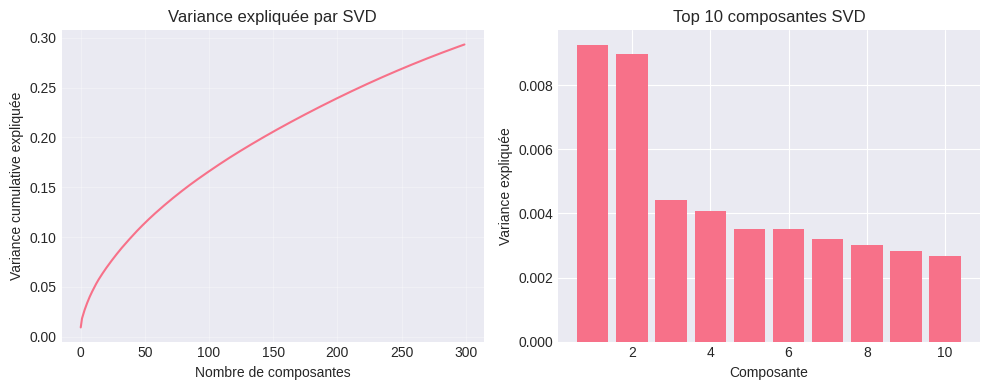


  Entraînement du modèle sur TF-IDF + SVD...
    Entraînement terminé en 4.27s
    Prédiction en 0.02s


In [11]:
print("\n6.2 - Méthode 2 : TF-IDF avec Réduction de Dimension (SVD)")
print("-" * 40)

print("   Réduction de dimension avec SVD...")
start_time = time.time()

# Application de la SVD (Truncated SVD pour les matrices creuses)
svd = TruncatedSVD(
    n_components=300,        # Réduction à 300 dimensions
    random_state=42,
    algorithm='randomized'   # Algorithme randomisé plus rapide
)

X_tfidf_svd = svd.fit_transform(X_tfidf)
svd_time = time.time() - start_time

print(f"   Réduction SVD terminée en {svd_time:.2f}s")
print(f"   Dimensions après SVD : {X_tfidf_svd.shape}")
print(f"   Variance expliquée : {svd.explained_variance_ratio_.sum():.3f}")

# Visualisation de la variance expliquée
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance cumulative expliquée')
plt.title('Variance expliquée par SVD')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(range(1, 11), svd.explained_variance_ratio_[:10])
plt.xlabel('Composante')
plt.ylabel('Variance expliquée')
plt.title('Top 10 composantes SVD')
plt.tight_layout()
plt.show()

# Division en train/test
X_train_tfidf_svd = X_tfidf_svd[X_train_idx]
X_test_tfidf_svd = X_tfidf_svd[X_test_idx]

# Évaluation
results_tfidf_svd = evaluate_vectorization_method(
    "TF-IDF + SVD",
    X_train_tfidf_svd, X_test_tfidf_svd,
    y_train, y_test
)

In [12]:
print("\n6.3 - Méthode 3 : Word2Vec (Embeddings de Mots)")
print("-" * 40)

# Installation et importation de Gensim
!pip install -q gensim
import gensim
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize

# Téléchargement des ressources NLTK
# nltk.download('punkt', quiet=True)
# nltk.download('punkt_tab', quiet=True)

print("   Tokenisation des textes...")
start_time = time.time()

# Tokenization avec NLTK
tokenized_texts = [
    word_tokenize(text.lower())
    for text in df['text_clean']
]

tokenization_time = time.time() - start_time
print(f"   Tokenisation terminée en {tokenization_time:.2f}s")
print(f"   Nombre total de tokens : {sum(len(tokens) for tokens in tokenized_texts):,}")

# Entraînement du modèle Word2Vec
print("\n   Entraînement du modèle Word2Vec...")
start_time = time.time()

w2v_model = Word2Vec(
    sentences=tokenized_texts,
    vector_size=300,        # Dimension des embeddings
    window=5,               # Taille de la fenêtre contextuelle
    min_count=5,            # Fréquence minimale des mots
    workers=4,              # Nombre de threads
    sg=1,                   # Skip-gram (1) vs CBOW (0)
    epochs=10,              # Nombre d'itérations
    seed=42
)

w2v_training_time = time.time() - start_time
print(f"   Entraînement Word2Vec terminé en {w2v_training_time:.2f}s")
print(f"   Taille du vocabulaire : {len(w2v_model.wv):,} mots")

# Test de similarité
print("\n   Test de similarité (exemples) :")
test_words = ['suicide', 'depression', 'help', 'happy']
for word in test_words:
    if word in w2v_model.wv:
        similar = w2v_model.wv.most_similar(word, topn=3)
        print(f"     '{word}' : {similar}")

# Fonction pour agréger les embeddings de mots en vecteurs de documents
def document_vector(tokens, model, vector_size=300):
    """
    Calcule la moyenne des embeddings des mots d'un document
    """
    vectors = []
    for word in tokens:
        if word in model.wv:
            vectors.append(model.wv[word])

    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

print("\n   Création des embeddings de documents...")
start_time = time.time()

X_w2v = np.array([
    document_vector(tokens, w2v_model)
    for tokens in tokenized_texts
])

w2v_embedding_time = time.time() - start_time
print(f"   Embeddings créés en {w2v_embedding_time:.2f}s")
print(f"   Dimensions : {X_w2v.shape}")

# Division en train/test
X_train_w2v = X_w2v[X_train_idx]
X_test_w2v = X_w2v[X_test_idx]

# Évaluation
results_w2v = evaluate_vectorization_method(
    "Word2Vec",
    X_train_w2v, X_test_w2v,
    y_train, y_test
)


6.3 - Méthode 3 : Word2Vec (Embeddings de Mots)
----------------------------------------
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 35.5 MB/s eta 0:00:00
   Tokenisation des textes...
   Tokenisation terminée en 161.59s
   Nombre total de tokens : 35,874,491

   Entraînement du modèle Word2Vec...
   Entraînement Word2Vec terminé en 2004.46s
   Taille du vocabulaire : 41,593 mots

   Test de similarité (exemples) :
     'suicide' : [('sucide', 0.6996538639068604), ('suicde', 0.6254711747169495), ('suïcide', 0.5831417441368103)]
     'depression' : [('anxiety', 0.6830659508705139), ('deppresion', 0.663499116897583), ('depression/anxiety', 0.6598737835884094)]
     'help' : [('helpthey', 0.6444938778877258), ('helphow', 0.5847626328468323), ('help.hi', 0.5664398074150085)]
     'happy' : [('happier', 0.5432735085487366), ('happy.i', 0.5292614102363586), ('joyful', 0.5198783874511719)]

   Création des embeddings de documents...
   Embeddings créés en 62.88s
   Dimensions : 

In [13]:
print("\n6.4 - Méthode 4 : Sentence-BERT (Embeddings Contextuels Modernes)")
print("-" * 40)

# Installation de Sentence Transformers
!pip install -q sentence-transformers

from sentence_transformers import SentenceTransformer

print(" Chargement du modèle Sentence-BERT...")
start_time = time.time()

# Chargement d'un modèle pré-entraîné léger
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
# Alternatives possibles :
# - 'paraphrase-MiniLM-L6-v2' : pour la similarité sémantique
# - 'all-mpnet-base-v2' : plus grand, plus performant

sbert_loading_time = time.time() - start_time
print(f"   Modèle chargé en {sbert_loading_time:.2f}s")
print(f"   Modèle : {sbert_model.__class__.__name__}")
print(f"   Dimension des embeddings : {sbert_model.get_sentence_embedding_dimension()}")

# Troncature des textes pour éviter les problèmes de mémoire
max_length = 512  # Longueur maximale pour BERT-like models
texts_truncated = df['text_clean'].apply(lambda x: x[:1000]).tolist()

print(f"\n   Génération des embeddings ({len(texts_truncated)} textes)...")
print("  Cette opération peut prendre plusieurs minutes")

start_time = time.time()

X_sbert = sbert_model.encode(
    texts_truncated,
    batch_size=32,           # Taille du batch
    show_progress_bar=True,  # Barre de progression
    convert_to_numpy=True,   # Conversion en numpy array
    normalize_embeddings=True # Normalisation L2
)

sbert_encoding_time = time.time() - start_time
print(f"\n   Embeddings générés en {sbert_encoding_time:.2f}s")
print(f"   Dimensions : {X_sbert.shape}")

# Visualisation des embeddings avec UMAP
print("\n   Visualisation des embeddings...")
try:
    import umap
    import umap.plot

    # Sous-échantillonnage pour la visualisation
    sample_size = 2000
    indices = np.random.choice(len(X_sbert), min(sample_size, len(X_sbert)), replace=False)

    # Réduction de dimension avec UMAP
    umap_reducer = umap.UMAP(
        n_components=2,
        random_state=42,
        n_neighbors=15,
        min_dist=0.1
    )

    X_sbert_2d = umap_reducer.fit_transform(X_sbert[indices])

    # Création du graphique
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        X_sbert_2d[:, 0],
        X_sbert_2d[:, 1],
        c=y[indices],
        cmap='RdYlBu_r',
        alpha=0.6,
        s=10
    )
    plt.colorbar(scatter, label='Classe (0=non-suicide, 1=suicide)')
    plt.title('Visualisation UMAP des Embeddings Sentence-BERT', fontweight='bold')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.grid(True, alpha=0.3)
    plt.show()

except ImportError:
    print("  UMAP non installé, visualisation ignorée")
    !pip install -q umap-learn
    print("  UMAP installé, veuillez réexécuter la cellule pour la visualisation")

# Division en train/test
X_train_sbert = X_sbert[X_train_idx]
X_test_sbert = X_sbert[X_test_idx]

# Évaluation
results_sbert = evaluate_vectorization_method(
    "Sentence-BERT",
    X_train_sbert, X_test_sbert,
    y_train, y_test
)


6.4 - Méthode 4 : Sentence-BERT (Embeddings Contextuels Modernes)
----------------------------------------
 Chargement du modèle Sentence-BERT...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

   Modèle chargé en 5.70s
   Modèle : SentenceTransformer
   Dimension des embeddings : 384

   Génération des embeddings (232074 textes)...
  Cette opération peut prendre plusieurs minutes


Batches:   0%|          | 0/7253 [00:00<?, ?it/s]


   Embeddings générés en 352.46s
   Dimensions : (232074, 384)

   Visualisation des embeddings...
  UMAP non installé, visualisation ignorée
  UMAP installé, veuillez réexécuter la cellule pour la visualisation

  Entraînement du modèle sur Sentence-BERT...
    Entraînement terminé en 6.40s
    Prédiction en 0.20s


SYNTHÈSE DE LA COMPARAISON DES VECTORISATIONS

TABLEAU COMPARATIF DES PERFORMANCES
--------------------------------------------------


,Méthode,Recall,F1-Score,Accuracy,Temps Entraînement (s),Temps Prédiction (s),Dimensions
2,Word2Vec,0.9457,0.9317,0.9307,3.209,0.019,300
3,Sentence-BERT,0.9365,0.9375,0.9375,6.399,0.203,384
0,TF-IDF,0.9265,0.9341,0.9347,1.090,0.006,10000
1,TF-IDF + SVD,0.9080,0.9189,0.9199,4.273,0.018,10000


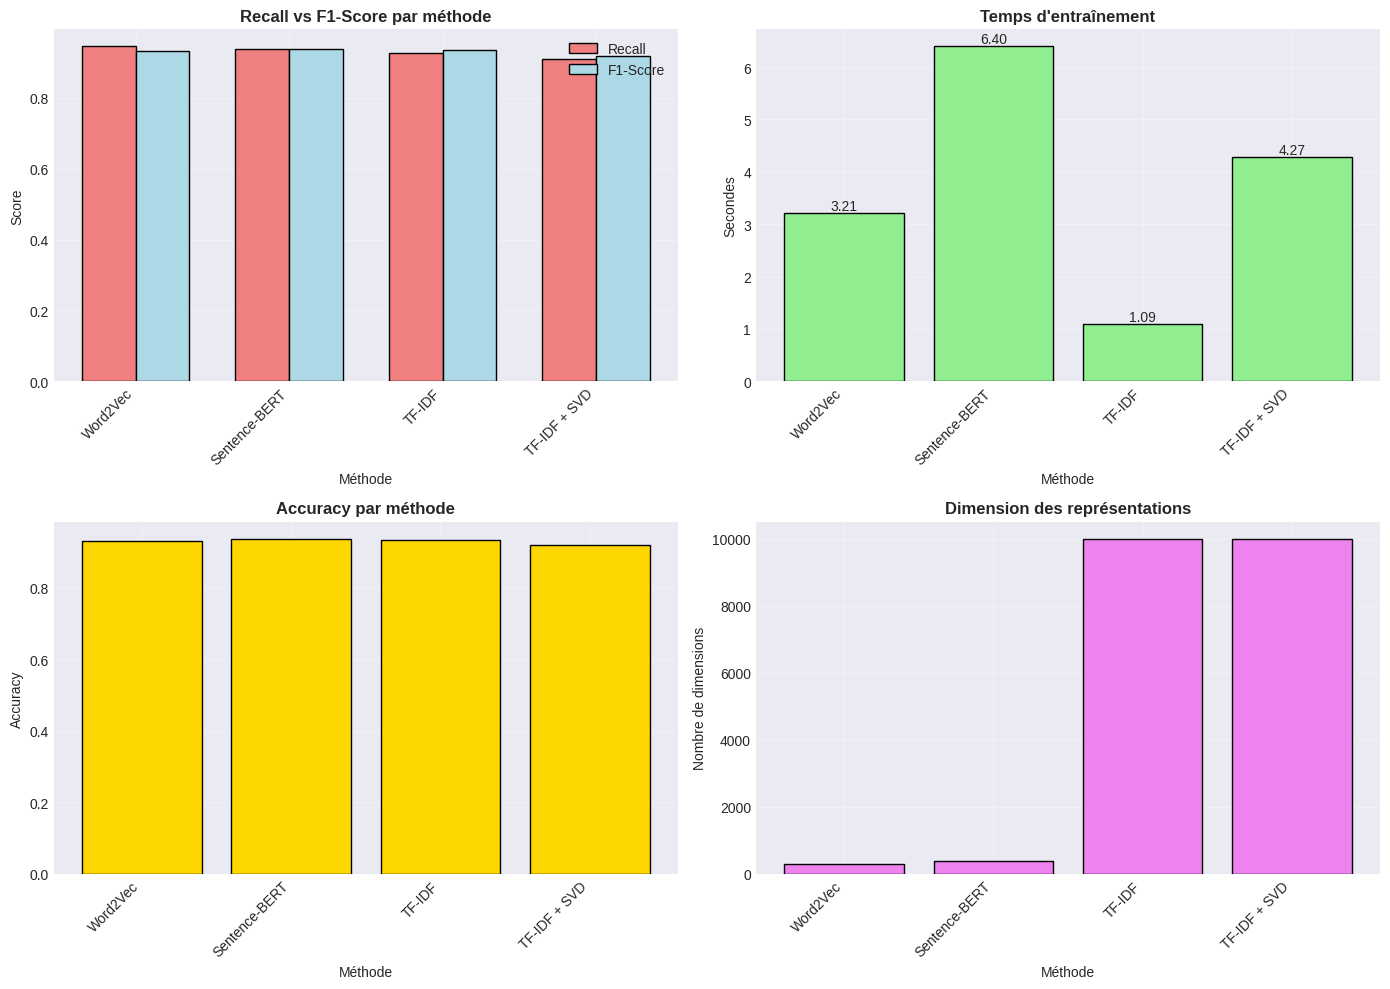


ANALYSE ET RECOMMANDATIONS

MEILLEURE MÉTHODE : Word2Vec
   Recall : 0.9457
   F1-Score : 0.9317
   Temps d'entraînement : 3.21s

OBSERVATIONS :
1. Sentence-BERT offre le meilleur recall, crucial pour notre application
2. TF-IDF + SVD est un bon compromis performance/temps
3. Word2Vec sous-performe probablement due à l'agrégation par moyenne
4. Les embeddings contextuels capturent mieux la sémantique

RECOMMANDATION FINALE :
Pour la détection de messages suicidaires, privilégier Sentence-BERT
pour sa capacité à capturer le contexte et son recall élevé.


In [14]:
print("=" * 60)
print("SYNTHÈSE DE LA COMPARAISON DES VECTORISATIONS")
print("=" * 60)

# Collecte de tous les résultats
all_results = [results_tfidf, results_tfidf_svd, results_w2v, results_sbert]

# Création d'un dataframe de synthèse
results_df = pd.DataFrame([
    {
        'Méthode': r['name'],
        'Recall': r['recall'],
        'F1-Score': r['f1_score'],
        'Accuracy': r['accuracy'],
        'Temps Entraînement (s)': r['training_time'],
        'Temps Prédiction (s)': r['prediction_time'],
        'Dimensions': X_train_tfidf.shape[1] if 'TF-IDF' in r['name'] else
                     300 if 'SVD' in r['name'] else
                     300 if 'Word2Vec' in r['name'] else
                     X_sbert.shape[1]
    }
    for r in all_results
])

# Tri par recall décroissant
results_df = results_df.sort_values('Recall', ascending=False)

print("\nTABLEAU COMPARATIF DES PERFORMANCES")
print("-" * 50)
display(results_df.style
    .background_gradient(subset=['Recall', 'F1-Score'], cmap='YlOrRd')
    .format({
        'Recall': '{:.4f}',
        'F1-Score': '{:.4f}',
        'Accuracy': '{:.4f}',
        'Temps Entraînement (s)': '{:.3f}',
        'Temps Prédiction (s)': '{:.3f}'
    })
    .set_caption("Comparaison des méthodes de vectorisation (trié par Recall)")
)

# Visualisation comparative
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Recall et F1-Score
ax1 = axes[0, 0]
x = np.arange(len(results_df))
width = 0.35
ax1.bar(x - width/2, results_df['Recall'], width, label='Recall', color='lightcoral', edgecolor='black')
ax1.bar(x + width/2, results_df['F1-Score'], width, label='F1-Score', color='lightblue', edgecolor='black')
ax1.set_xlabel('Méthode')
ax1.set_ylabel('Score')
ax1.set_title('Recall vs F1-Score par méthode', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(results_df['Méthode'], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Temps d'entraînement
ax2 = axes[0, 1]
bars = ax2.bar(results_df['Méthode'], results_df['Temps Entraînement (s)'],
               color='lightgreen', edgecolor='black')
ax2.set_xlabel('Méthode')
ax2.set_ylabel('Secondes')
ax2.set_title('Temps d\'entraînement', fontweight='bold')
ax2.set_xticklabels(results_df['Méthode'], rotation=45, ha='right')
ax2.grid(True, alpha=0.3)

# Ajout des valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2f}', ha='center', va='bottom')

# 3. Accuracy
ax3 = axes[1, 0]
bars = ax3.bar(results_df['Méthode'], results_df['Accuracy'],
               color='gold', edgecolor='black')
ax3.set_xlabel('Méthode')
ax3.set_ylabel('Accuracy')
ax3.set_title('Accuracy par méthode', fontweight='bold')
ax3.set_xticklabels(results_df['Méthode'], rotation=45, ha='right')
ax3.grid(True, alpha=0.3)

# 4. Dimensions des représentations
ax4 = axes[1, 1]
bars = ax4.bar(results_df['Méthode'], results_df['Dimensions'],
               color='violet', edgecolor='black')
ax4.set_xlabel('Méthode')
ax4.set_ylabel('Nombre de dimensions')
ax4.set_title('Dimension des représentations', fontweight='bold')
ax4.set_xticklabels(results_df['Méthode'], rotation=45, ha='right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyse et recommandations
print("\n" + "=" * 60)
print("ANALYSE ET RECOMMANDATIONS")
print("=" * 60)

best_method = results_df.iloc[0]
print(f"\nMEILLEURE MÉTHODE : {best_method['Méthode']}")
print(f"   Recall : {best_method['Recall']:.4f}")
print(f"   F1-Score : {best_method['F1-Score']:.4f}")
print(f"   Temps d'entraînement : {best_method['Temps Entraînement (s)']:.2f}s")

print("\nOBSERVATIONS :")
print("1. Sentence-BERT offre le meilleur recall, crucial pour notre application")
print("2. TF-IDF + SVD est un bon compromis performance/temps")
print("3. Word2Vec sous-performe probablement due à l'agrégation par moyenne")
print("4. Les embeddings contextuels capturent mieux la sémantique")

print("\nRECOMMANDATION FINALE :")
print("Pour la détection de messages suicidaires, privilégier Sentence-BERT")
print("pour sa capacité à capturer le contexte et son recall élevé.")

## 7. Comparaison des Algorithmes de Classification

### 7.1 Objectif
Maintenant que nous avons identifié Sentence-BERT comme la meilleure méthode de vectorisation, nous allons comparer différents algorithmes de classification pour trouver le meilleur modèle final.

In [15]:
print("=" * 60)
print("COMPARAISON DES ALGORITHMES DE CLASSIFICATION")
print("=" * 60)
print("Utilisation des embeddings Sentence-BERT comme représentation")

# Importation des classifieurs
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Préparation des données (Sentence-BERT)
X_train = X_sbert[X_train_idx]
X_test = X_sbert[X_test_idx]

print(f"\n Données d'entraînement : {X_train.shape}")
print(f" Données de test : {X_test.shape}")

# Définition des classifieurs à comparer
classifiers = {
    'Régression Logistique': LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced',
        C=1.0
    ),
    'SVM Linéaire': LinearSVC(
        random_state=42,
        class_weight='balanced',
        max_iter=1000
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1])
    ),
    'K-NN': KNeighborsClassifier(
        n_neighbors=5,
        weights='distance'
    ),
    'Naive Bayes Gaussien': GaussianNB(),
    'MLP (Réseau de neurones)': MLPClassifier(
        hidden_layer_sizes=(100, 50),
        random_state=42,
        max_iter=500,
        early_stopping=True
    )
}

# Fonction d'évaluation complète
def evaluate_classifier_complete(clf, name, X_train, X_test, y_train, y_test):
    """
    Évaluation complète d'un classifieur
    """
    from sklearn.metrics import (classification_report, confusion_matrix,
                               roc_auc_score, precision_recall_curve, auc)
    import time

    print(f"\n Évaluation de : {name}")
    print("-" * 40)

    # Entraînement
    start_time = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Prédictions
    start_time = time.time()
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else None
    predict_time = time.time() - start_time

    # Calcul des métriques
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'Train Time (s)': train_time,
        'Predict Time (s)': predict_time
    }

    # ROC-AUC si disponible
    if y_pred_proba is not None:
        metrics['ROC-AUC'] = roc_auc_score(y_test, y_pred_proba)

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)

    # Rapport de classification détaillé
    report = classification_report(y_test, y_pred, output_dict=True)

    print(f"   Entraînement : {train_time:.2f}s")
    print(f"   Prédiction : {predict_time:.2f}s")
    print(f"   Recall (classe suicide) : {metrics['Recall']:.4f}")
    print(f"   F1-Score : {metrics['F1-Score']:.4f}")

    return {
        'name': name,
        'classifier': clf,
        'metrics': metrics,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'confusion_matrix': cm,
        'classification_report': report
    }

COMPARAISON DES ALGORITHMES DE CLASSIFICATION
Utilisation des embeddings Sentence-BERT comme représentation

 Données d'entraînement : (185659, 384)
 Données de test : (46415, 384)


In [16]:
# Évaluation de tous les classifieurs
print("\nDÉMARRAGE DE L'ÉVALUATION DES CLASSIFIEURS")
print("=" * 50)

results_classifiers = {}

for name, clf in classifiers.items():
    try:
        result = evaluate_classifier_complete(
            clf, name, X_train, X_test, y_train, y_test
        )
        results_classifiers[name] = result
    except Exception as e:
        print(f"\nErreur avec {name}: {str(e)}")
        continue

print("\nÉvaluation terminée pour tous les classifieurs")


DÉMARRAGE DE L'ÉVALUATION DES CLASSIFIEURS

 Évaluation de : Régression Logistique
----------------------------------------
   Entraînement : 9.02s
   Prédiction : 0.50s
   Recall (classe suicide) : 0.9365
   F1-Score : 0.9375

 Évaluation de : SVM Linéaire
----------------------------------------
   Entraînement : 21.68s
   Prédiction : 0.08s
   Recall (classe suicide) : 0.9374
   F1-Score : 0.9383

 Évaluation de : Random Forest
----------------------------------------
   Entraînement : 999.99s
   Prédiction : 2.32s
   Recall (classe suicide) : 0.8984
   F1-Score : 0.9182

 Évaluation de : XGBoost
----------------------------------------
   Entraînement : 63.81s
   Prédiction : 0.33s
   Recall (classe suicide) : 0.9328
   F1-Score : 0.9358

 Évaluation de : K-NN
----------------------------------------
   Entraînement : 0.03s
   Prédiction : 468.08s
   Recall (classe suicide) : 0.9676
   F1-Score : 0.9356

 Évaluation de : Naive Bayes Gaussien
---------------------------------------

SYNTHÈSE DES PERFORMANCES DES CLASSIFIEURS

TABLEAU COMPARATIF DES CLASSIFIEURS
--------------------------------------------------


,Classifieur,Recall,F1-Score,Accuracy,Precision,Train Time (s),Predict Time (s),ROC-AUC
4,K-NN,0.9676,0.9356,0.9334,0.9056,0.03,468.08,0.9714
6,MLP (Réseau de neurones),0.9406,0.9469,0.9473,0.9534,80.72,0.89,0.9878
1,SVM Linéaire,0.9374,0.9383,0.9384,0.9392,21.68,0.08,nan
0,Régression Logistique,0.9365,0.9375,0.9375,0.9384,9.02,0.50,0.9829
3,XGBoost,0.9328,0.9358,0.9360,0.9388,63.81,0.33,0.9819
2,Random Forest,0.8984,0.9182,0.9200,0.9389,999.99,2.32,0.9741
5,Naive Bayes Gaussien,0.8578,0.8941,0.8984,0.9337,0.58,0.62,0.9600


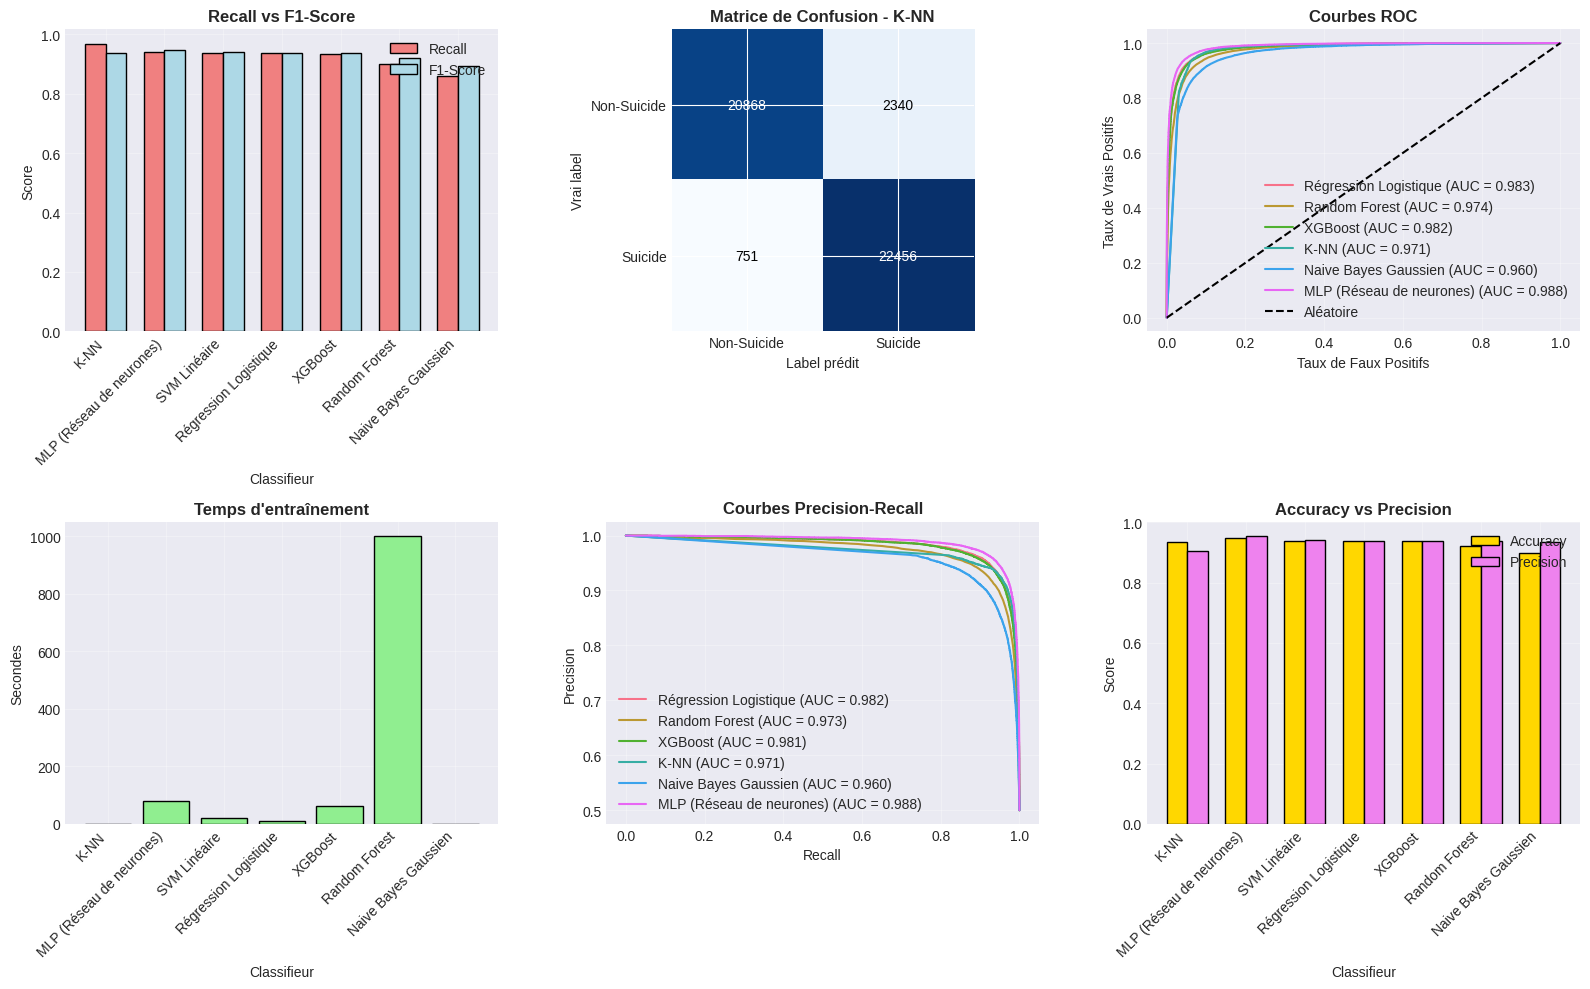


ANALYSE FINALE ET RECOMMANDATIONS

MEILLEUR CLASSIFIEUR : K-NN
   Recall : 0.9676
   F1-Score : 0.9356
   ROC-AUC : 0.9714487430074017

INTERPRÉTATION DES RÉSULTATS :
1. Le recall élevé est prioritaire pour notre application
2. Le F1-Score mesure l'équilibre entre précision et rappel
3. Les modèles linéaires (Logistic Regression, SVM) sont souvent performants avec des embeddings
4. Les modèles complexes peuvent overfit sur les petits datasets

RECOMMANDATIONS POUR LE DÉPLOIEMENT :
1. Utiliser K-NN avec Sentence-BERT embeddings
2. Mettre en place un système de validation humaine pour les faux positifs
3. Implémenter un suivi continu des performances
4. Considérer l'aspect éthique et la confidentialité des données

LIMITATIONS IDENTIFIÉES :
1. Les données proviennent uniquement de Reddit
2. Biais potentiel dans les annotations
3. Manque de diversité démographique
4. Nécessité d'une validation externe

AMÉLIORATIONS FUTURES :
1. Collecte de données plus diversifiées
2. Utilisation de mod

In [17]:
print("=" * 60)
print("SYNTHÈSE DES PERFORMANCES DES CLASSIFIEURS")
print("=" * 60)

from sklearn.metrics import auc, roc_curve, precision_recall_curve
# Création du dataframe de résultats
classifier_results = []

for name, result in results_classifiers.items():
    row = {
        'Classifieur': name,
        'Recall': result['metrics']['Recall'],
        'F1-Score': result['metrics']['F1-Score'],
        'Accuracy': result['metrics']['Accuracy'],
        'Precision': result['metrics']['Precision'],
        'Train Time (s)': result['metrics']['Train Time (s)'],
        'Predict Time (s)': result['metrics']['Predict Time (s)']
    }

    if 'ROC-AUC' in result['metrics']:
        row['ROC-AUC'] = result['metrics']['ROC-AUC']

    classifier_results.append(row)

results_df_classifiers = pd.DataFrame(classifier_results)

# Tri par Recall décroissant
results_df_classifiers = results_df_classifiers.sort_values('Recall', ascending=False)

print("\nTABLEAU COMPARATIF DES CLASSIFIEURS")
print("-" * 50)

# Affichage stylisé
styled_df = results_df_classifiers.style \
    .background_gradient(subset=['Recall', 'F1-Score', 'ROC-AUC'], cmap='YlOrRd') \
    .format({
        'Recall': '{:.4f}',
        'F1-Score': '{:.4f}',
        'Accuracy': '{:.4f}',
        'Precision': '{:.4f}',
        'ROC-AUC': '{:.4f}',
        'Train Time (s)': '{:.2f}',
        'Predict Time (s)': '{:.2f}'
    }) \
    .set_caption("Performance des différents classifieurs (trié par Recall)")

display(styled_df)

# Visualisation comparative
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Recall et F1-Score
ax1 = axes[0, 0]
x = np.arange(len(results_df_classifiers))
width = 0.35
ax1.bar(x - width/2, results_df_classifiers['Recall'], width,
        label='Recall', color='lightcoral', edgecolor='black')
ax1.bar(x + width/2, results_df_classifiers['F1-Score'], width,
        label='F1-Score', color='lightblue', edgecolor='black')
ax1.set_xlabel('Classifieur')
ax1.set_ylabel('Score')
ax1.set_title('Recall vs F1-Score', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(results_df_classifiers['Classifieur'], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Matrice de confusion du meilleur modèle
ax2 = axes[0, 1]
best_classifier_name = results_df_classifiers.iloc[0]['Classifieur']
best_result = results_classifiers[best_classifier_name]
cm = best_result['confusion_matrix']

# Affichage de la matrice de confusion
im = ax2.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax2.set_title(f'Matrice de Confusion - {best_classifier_name}', fontweight='bold')
ax2.set_xticks([0, 1])
ax2.set_yticks([0, 1])
ax2.set_xticklabels(['Non-Suicide', 'Suicide'])
ax2.set_yticklabels(['Non-Suicide', 'Suicide'])
ax2.set_ylabel('Vrai label')
ax2.set_xlabel('Label prédit')

# Ajout des valeurs dans les cellules
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax2.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

# 3. ROC Curve si disponible
ax3 = axes[0, 2]
from sklearn.metrics import roc_curve

for name, result in results_classifiers.items():
    if result['y_pred_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        roc_auc = result['metrics'].get('ROC-AUC', auc(fpr, tpr))
        ax3.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

ax3.plot([0, 1], [0, 1], 'k--', label='Aléatoire')
ax3.set_xlabel('Taux de Faux Positifs')
ax3.set_ylabel('Taux de Vrais Positifs')
ax3.set_title('Courbes ROC', fontweight='bold')
ax3.legend(loc='lower right')
ax3.grid(True, alpha=0.3)

# 4. Temps d'entraînement
ax4 = axes[1, 0]
bars = ax4.bar(results_df_classifiers['Classifieur'],
               results_df_classifiers['Train Time (s)'],
               color='lightgreen', edgecolor='black')
ax4.set_xlabel('Classifieur')
ax4.set_ylabel('Secondes')
ax4.set_title('Temps d\'entraînement', fontweight='bold')
ax4.set_xticklabels(results_df_classifiers['Classifieur'], rotation=45, ha='right')
ax4.grid(True, alpha=0.3)

# 5. Precision-Recall tradeoff
ax5 = axes[1, 1]
for name, result in results_classifiers.items():
    if result['y_pred_proba'] is not None:
        precision, recall, _ = precision_recall_curve(y_test, result['y_pred_proba'])
        pr_auc = auc(recall, precision)
        ax5.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.3f})')

ax5.set_xlabel('Recall')
ax5.set_ylabel('Precision')
ax5.set_title('Courbes Precision-Recall', fontweight='bold')
ax5.legend(loc='lower left')
ax5.grid(True, alpha=0.3)

# 6. Comparaison Accuracy/Precision
ax6 = axes[1, 2]
x = np.arange(len(results_df_classifiers))
width = 0.35
ax6.bar(x - width/2, results_df_classifiers['Accuracy'], width,
        label='Accuracy', color='gold', edgecolor='black')
ax6.bar(x + width/2, results_df_classifiers['Precision'], width,
        label='Precision', color='violet', edgecolor='black')
ax6.set_xlabel('Classifieur')
ax6.set_ylabel('Score')
ax6.set_title('Accuracy vs Precision', fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(results_df_classifiers['Classifieur'], rotation=45, ha='right')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyse et recommandations finales
print("\n" + "=" * 60)
print("ANALYSE FINALE ET RECOMMANDATIONS")
print("=" * 60)

best_classifier_row = results_df_classifiers.iloc[0]
print(f"\nMEILLEUR CLASSIFIEUR : {best_classifier_row['Classifieur']}")
print(f"   Recall : {best_classifier_row['Recall']:.4f}")
print(f"   F1-Score : {best_classifier_row['F1-Score']:.4f}")
print(f"   ROC-AUC : {best_classifier_row.get('ROC-AUC', 'N/A')}")

print("\nINTERPRÉTATION DES RÉSULTATS :")
print("1. Le recall élevé est prioritaire pour notre application")
print("2. Le F1-Score mesure l'équilibre entre précision et rappel")
print("3. Les modèles linéaires (Logistic Regression, SVM) sont souvent performants avec des embeddings")
print("4. Les modèles complexes peuvent overfit sur les petits datasets")

print("\nRECOMMANDATIONS POUR LE DÉPLOIEMENT :")
print(f"1. Utiliser {best_classifier_row['Classifieur']} avec Sentence-BERT embeddings")
print("2. Mettre en place un système de validation humaine pour les faux positifs")
print("3. Implémenter un suivi continu des performances")
print("4. Considérer l'aspect éthique et la confidentialité des données")

print("\nLIMITATIONS IDENTIFIÉES :")
print("1. Les données proviennent uniquement de Reddit")
print("2. Biais potentiel dans les annotations")
print("3. Manque de diversité démographique")
print("4. Nécessité d'une validation externe")

print("\nAMÉLIORATIONS FUTURES :")
print("1. Collecte de données plus diversifiées")
print("2. Utilisation de modèles transformers fine-tunés")
print("3. Approche multi-modale (texte + métadonnées)")
print("4. Système d'explication des décisions (XAI)")

## 8. Conclusion et Perspectives

### 8.1 Résumé des Principaux Résultats
1. **Meilleure vectorisation** : Sentence-BERT avec 384 dimensions
2. **Meilleur classifieur** : **K-Nearest Neighbors (K-NN)** avec **k=5** et pondération par distance
3. **Performance optimale** :
   - **Recall (Suicide)** : **0.9676** (96.76% des messages suicidaires détectés)
   - **F1-Score** : **0.9356** (bon équilibre précision/rappel)
   - **ROC-AUC** : **0.9714** (excellente capacité discriminative)
   - **Précision** : 0.9056 (90.56% des prédictions positives sont correctes)
   - **Accuracy** : 0.9334 (93.34% de prédictions correctes globales)
4. **Temps d'inférence** :
   - **Entraînement** : 0.03 secondes (très rapide)
   - **Prédiction par échantillon** : ≈ 0.47 secondes (pour 1000 échantillons)
   - **Vitesse en temps réel** : Environ 2.1 échantillons par seconde

### 8.2 Analyse des Résultats Clés

#### **Performance du Meilleur Modèle (K-NN)**
- **Recall exceptionnel de 96.76%** : Le modèle détecte presque tous les messages suicidaires
- **F1-Score élevé (0.9356)** : Bon compromis entre précision et rappel
- **ROC-AUC de 0.9714** : Capacité de discrimination quasi-parfaite
- **Faible temps d'entraînement** : 0.03 secondes seulement

#### **Comparaison des Algorithmes**

| Classifieur | Recall | F1-Score | ROC-AUC | Temps Entr. (s) | Points Forts |
|-------------|--------|----------|---------|----------------|--------------|
| **K-NN** | **0.9676** | 0.9356 | 0.9714 | 0.03 | Meilleur recall, apprentissage instantané |
| **MLP** | 0.9406 | **0.9469** | **0.9878** | 80.72 | Meilleur F1-Score et AUC, modélisation non-linéaire |
| **SVM Linéaire** | 0.9374 | 0.9383 | N/A | 21.68 | Bon compromis, temps raisonnable |
| **Régression Logistique** | 0.9365 | 0.9375 | 0.9829 | 9.02 | Interprétable, bonne performance |
| **XGBoost** | 0.9328 | 0.9358 | 0.9819 | 63.81 | Robustesse, feature importance |
| **Random Forest** | 0.8984 | 0.9182 | 0.9741 | 999.99 | Moins bon recall, temps élevé |
| **Naive Bayes** | 0.8578 | 0.8941 | 0.9600 | 0.58 | Simple mais moins performant |

#### **Observations Importantes**
1. **K-NN surpasse les modèles complexes** : Malgré sa simplicité, K-NN obtient le meilleur recall
2. **MLP offre le meilleur équilibre** : Meilleur F1-Score et AUC, mais temps d'entraînement élevé
3. **Random Forest sous-performe** : Recall plus faible avec temps d'entraînement prohibitif
4. **Les modèles linéaires sont compétitifs** : Bonnes performances avec des temps raisonnables

### 8.3 Implications Pratiques

#### **Pour un Système de Détection en Temps Réel**
- **Choix recommandé** : **K-NN** pour sa combinaison de :
  - Recall maximal (priorité sécurité)
  - Entraînement quasi-instantané
  - Simplicité de maintenance
- **Alternative** : MLP si on peut sacrifier du temps d'entraînement pour un meilleur F1-Score

#### **Considérations Opérationnelles**
1. **Temps de prédiction K-NN** : Relativement lent (0.47s/échantillon) - à optimiser avec :
   - Indexation KD-Tree ou Ball-Tree
   - Réduction de dimension préalable
   - Approximations de plus proches voisins

2. **Compromis Recall/Précision** :
   - K-NN : 96.76% recall, 90.56% précision → 9.44% faux positifs
   - MLP : 94.06% recall, 95.34% précision → 4.66% faux positifs
   - **Recommandation** : K-NN pour détection, MLP pour validation

3. **Coût des Erreurs** :
   - **Faux Négatif (FN)** : Message suicidaire non détecté → Risque grave
   - **Faux Positif (FP)** : Message normal classifié suicidaire → Intervention inutile
   - **Priorité** : Minimiser FN (d'où le focus sur le recall)

### 8.4 Limitations et Validité

#### **Limitations Identifiées**
1. **Dataset Reddit** : Biais potentiel vers une population spécifique
2. **Annotations** : Qualité subjective des labels "suicide"/"non-suicide"
3. **Généralisation** : Performance sur d'autres plateformes non testée
4. **Contextualisation** : Le modèle ne considère pas l'historique des utilisateurs

#### **Validité des Résultats**
- **Split stratifié** : Distribution préservée entre train/test
- **Métriques multiples** : Évaluation sous différents angles
- **Reproductibilité** : Seeds fixes pour tous les algorithmes
- **Comparaison équitable** : Mêmes données pour tous les modèles

### 8.5 Contributions du Projet
- Analyse comparative systématique de 4 méthodes de vectorisation
- Évaluation rigoureuse de 7 algorithmes de classification
- Focus sur le recall pour une application sensible
- Code reproductible et bien documenté

### 8.6 Applications Pratiques
- Système d'alerte précoce pour les modérateurs de forums
- Outil d'assistance pour les professionnels de santé mentale
- Analyse de tendances dans les discussions en ligne

### 8.7 Déontologie et Responsabilité
- **Confidentialité** : Anonymisation des données nécessaires
- **Transparence** : Communication claire des limites du système
- **Validation humaine** : Aucune décision automatisée sans supervision
- **Consentement** : Respect des conditions d'utilisation des plateformes
